# Unsupervised Learning Project | Vehicle Silhouettes

## 1 - Project Objective

**Prospect Auto**, a chain of car repair shops, has again requested a model that can automatically differentiate vehicles into three categories using geometric features extracted from their silhouettes: `bus`, `van`, and `car`.

In the previous project, a **supervised learning approach** was applied using labeled data, and the results demonstrated that silhouette‑based features are sufficient for reliable classification. That analysis and its conclusions can be found in the [Supervised Learning Project Notebook](../notebooks/01-supervised.ipynb).

This project extends that work by exploring whether **unsupervised learning techniques** can uncover the same class structure without relying on labels during training. The purpose is to evaluate whether clustering and dimensionality reduction methods can effectively separate the vehicle types based solely on their silhouette features.

The workflow for this analysis includes:

- Preparing the dataset by normalizing and standardizing its features.
- Exploring dimensionality reduction (e.g., PCA) to verify if the 18 original features can be reduced while preserving variance, and assessing its effectiveness for this problem.
- Applying clustering algorithms to group vehicles and evaluating clustering performance using appropriate metrics.
- Comparing the effectiveness of unsupervised clustering with the previously developed supervised models.
- Concluding whether unsupervised learning is a viable alternative for Prospect Auto’s classification needs.

## 2 – Data Import

 ### 2.1 Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# Dimensionality reduction
from sklearn.decomposition import PCA

# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Model evaluation metrics
from sklearn.metrics import silhouette_score

### 2.2 Load Cleaned Dataset

After completing the data cleaning process in the supervised project, I exported the final preprocessed dataset to a CSV file, preserving all applied transformations in a reusable format. In this notebook, I simply reload that cleaned dataset to continue with the unsupervised learning workflow.

In [2]:
# Read vehicle dataset as pandas DataFrame
df = pd.read_csv("../data/vehicle-silhouettes-clean.csv")

# Confirm vehicle dataset has loaded successfully
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


## 3 - Unsupervised Learning Model

### 3.1 Data Preparation

Before applying clustering algorithms, I prepare the dataset by separating the silhouette features (X) from the target labels (y). The labels are retained only for evaluation purposes and are not used during model training.

In [3]:
# Define features (X) and target (y)
X = df.drop(columns=['class'])
y = df['class']

# Quick check to confirm `class' not included to prevent data leakage
print(sorted(X.columns))

['circularity', 'compactness', 'distance_circularity', 'elongatedness', 'hollows_ratio', 'max.length_aspect_ratio', 'max.length_rectangularity', 'pr.axis_aspect_ratio', 'pr.axis_rectangularity', 'radius_ratio', 'scaled_radius_of_gyration', 'scaled_radius_of_gyration.1', 'scaled_variance', 'scaled_variance.1', 'scatter_ratio', 'skewness_about', 'skewness_about.1', 'skewness_about.2']


Because PCA and all three clustering algorithms are sensitive to feature scale, I applied **StandardScaler** to ensure each feature contributes equally. While **RobustScaler** can be useful in the presence of extreme outliers, StandardScaler provides a consistent baseline and is the most appropriate choice for this dataset.

In [4]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Quick statistical check to confirm scaling
# Expect mean ~ 0 and std ~ 1 across features
print("Scaling check:",
      "mean ~", X_scaled_df.mean().mean().round(3),
      "std ~", X_scaled_df.std().mean().round(3))

Scaling check: mean ~ -0.0 std ~ 1.001


### 3.2 Exploring Dimensionality Reduction

In the supervised learning project, the correlation heatmap revealed strong relationships among several silhouette features, suggesting redundancy in the dataset. To formally test this, I apply Principal Component Analysis (PCA) to evaluate whether the 18 features can be reduced while still preserving most of the variance. The first step is to fit PCA on the scaled features so it can compute the principal components.

In [5]:
# Initialize PCA (compute all components first)
pca = PCA()
pca.fit(X_scaled_df)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",None
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized S

With PCA fitted on the scaled features, the next step is to examine how much variance each principal component explains. This helps determine whether the original 18 features can be represented in fewer dimensions without losing significant information. To make these results more interpretable, I summarize the explained variance and cumulative variance in a table, which highlights how many components are needed to capture the majority of the dataset’s structure.

In [6]:
# Explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance = explained_variance.cumsum()

# Build a summary table for readability/interpretation
pca_table = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(explained_variance))],
    "Explained Variance (%)": np.round(explained_variance * 100, 2),
    "Cumulative Variance (%)": np.round(cumulative_variance * 100, 2)
})

pca_table

,Principal Component,Explained Variance (%),Cumulative Variance (%)
0,PC1,52.45,52.45
1,PC2,16.59,69.04
2,PC3,10.64,79.68
3,PC4,6.49,86.18
4,PC5,5.16,91.33
5,PC6,2.95,94.28
6,PC7,1.99,96.28
7,PC8,1.23,97.51
8,PC9,0.87,98.38
9,PC10,0.52,98.89


The first five principal components already explain over 91% of the variance, indicating that the dataset can be effectively reduced from 18 features to 5 without significant information loss. Retaining 6–8 components increases the captured variance to ~97%, but beyond this point, the incremental gains are negligible. The final component (PC18) contributes no variance, confirming redundancy in the original feature set.

While the table provides precise values, visualizing the explained and cumulative variance makes the trade‑off between dimensionality and information retention easier to interpret, with the bar chart and scree plot clearly highlighting the point of diminishing returns.

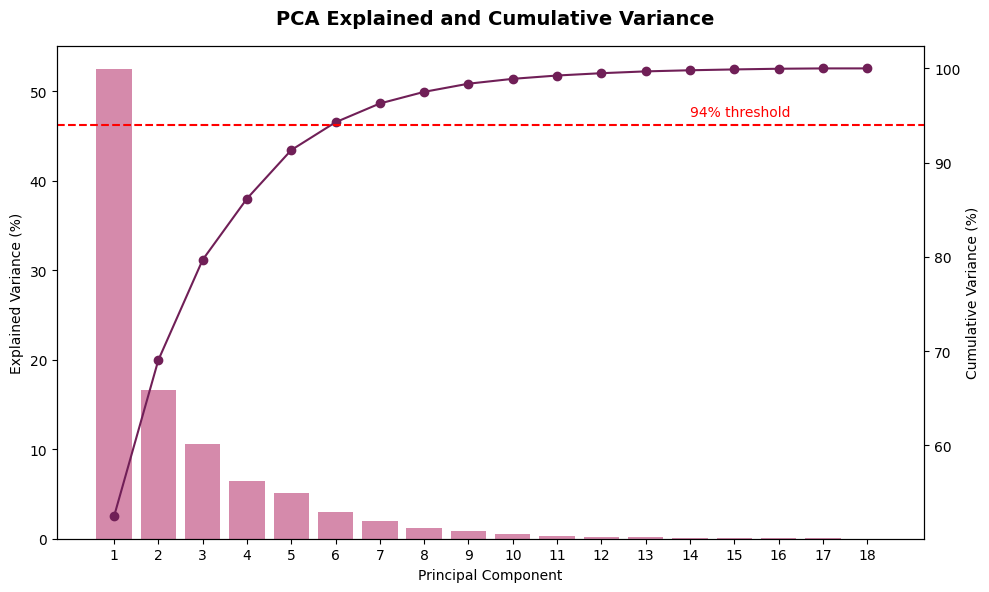

In [7]:
# Creating the plot figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Visualize explained variance with bar plot
ax1.bar(range(1, len(explained_variance) + 1),
        explained_variance*100,
        color=sns.color_palette("rocket")[2],
        alpha=0.5,
        label='Explained Variance (%)')

# Add title, labels and tick locations
fig.suptitle('PCA Explained and Cumulative Variance', fontsize=14, fontweight='bold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance (%)')
ax1.set_xticks(range(1, len(explained_variance)+1));

# Create a secondary y-axis for cumulative variance
ax2 = ax1.twinx()

# Visualize cumulative variance as a line with markers
ax2.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance*100,
    color=sns.color_palette("rocket")[1],
    marker='o',
    label='Cumulative Variance (%)');

# Add y-axis label for the secondary axis
ax2.set_ylabel('Cumulative Variance (%)')

# Add a horizontal reference line at 94%
ax2.axhline(y=94, color='red', linestyle='--', linewidth=1.5)
ax2.text(len(cumulative_variance)-4, 95, '94% threshold', color='red');

# Display plot
plt.tight_layout()
plt.show()

Based on the variance analysis table and the accompanying visualization, dimensionality reduction proved efficient, so I will retain the first six principal components for further analysis. Together they account for 94% of the dataset’s variance, providing a strong balance between dimensionality reduction and information preservation. The sharp decline in variance contribution after PC6, along with the plateauing cumulative variance curve, indicates that additional components add little value. All subsequent clustering and evaluation will be performed on this reduced six‑component representation of the data.

In [8]:
# Re-run PCA with 6 components and transform the dataset
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled_df)

# Confirm reduction in components
print("Original shape:", X_scaled_df.shape)
print("Reduced shape:", X_pca.shape)

Original shape: (813, 18)
Reduced shape: (813, 6)


### 3.3 Clustering Algorithms

#### 3.3.1 K-Means

**K‑Means** is one of the most popular clustering algorithms due to its simplicity and efficiency. It groups data points in **$k$ clusters** based on similarity. However, the number of clusters must be specified in advance. To determine a suitable value of $k$, I begin with the elbow method, which evaluates how inertia decreases as the number of clusters increases.

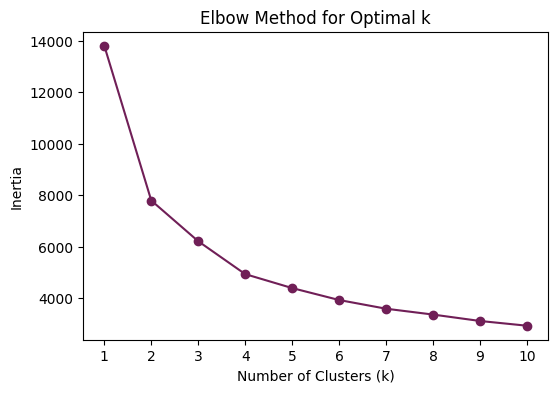

In [9]:
# Range of k values to test
k_values = range(1, 11)
inertia = []

# Compute inertia for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Creating the plot figure
plt.figure(figsize=(6,4))

# Plot the elbow curve
plt.plot(
    k_values,
    inertia,
    marker='o',
    color=sns.color_palette("rocket")[1],
    linestyle='-')

# Add title, labels and tick locations
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values);

# Display plot
plt.show()

The elbow plot suggests diminishing returns after three clusters, but the exact ‘elbow’ point is somewhat ambiguous, with a modest improvement still visible at four clusters. To strengthen the analysis and validate the choice of $k$, I also apply the silhouette method. This approach evaluates how well each data point fits within its assigned cluster compared to neighboring clusters, offering a complementary perspective on cluster quality.

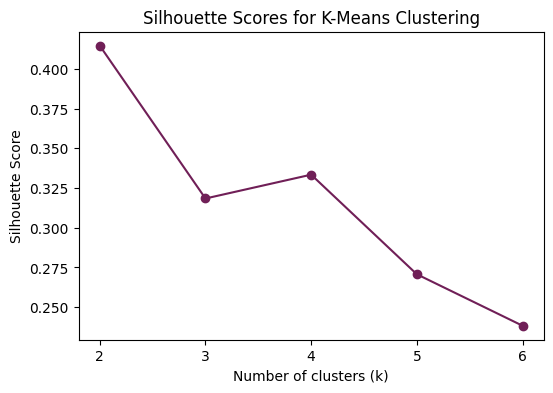

In [10]:
# Range of k values to test
k_values = range(2, 7)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Creating the plot figure
plt.figure(figsize=(6,4))

# Plot the silhouette scores
plt.plot(
    k_values,
    silhouette_scores,
    marker='o',
    color=sns.color_palette("rocket")[1],
    linestyle='-')

# Add title, labels and tick locations
plt.title("Silhouette Scores for K-Means Clustering")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values);

# Display plot
plt.show()

The silhouette analysis shows that two clusters achieve the strongest separation, but this solution does not align with the three underlying classes in the dataset. While the silhouette score for three clusters is lower, it still represents a meaningful partition and corresponds more closely to the expected categories of cars, vans, and buses. A fourth cluster provides only a marginal improvement in cohesion and separation, while higher values of $k$ lead to poorly defined groups. Taken together with the elbow method, these results support selecting $k = 3$ as the most practical balance between clustering quality and alignment with the dataset’s true class structure.

In [11]:
# Create KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Fit the model to the data
kmeans.fit(X_pca)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",3
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",10
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [12]:
# Convert numpy array back to DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Add cluster labels as a new column
X_pca_df['Cluster'] = kmeans.labels_

# Preview data to confirm new column
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Cluster
0,0.352249,0.141027,0.961832,-0.190872,0.069616,0.740301,0
1,-1.578072,0.422197,-0.365261,-0.239334,0.685899,0.530580,0
2,3.782556,-0.253257,0.061756,-1.216416,0.717337,-0.728388,1
3,-1.713214,2.819496,0.186835,-0.379588,-0.357389,0.514101,0
4,0.532165,-5.153595,11.400516,-0.066717,3.242363,0.360525,2


In [13]:
# Check the number of samples in each cluster
X_pca_df['Cluster'].value_counts()

Cluster
0    314
1    260
2    239
Name: count, dtype: int64

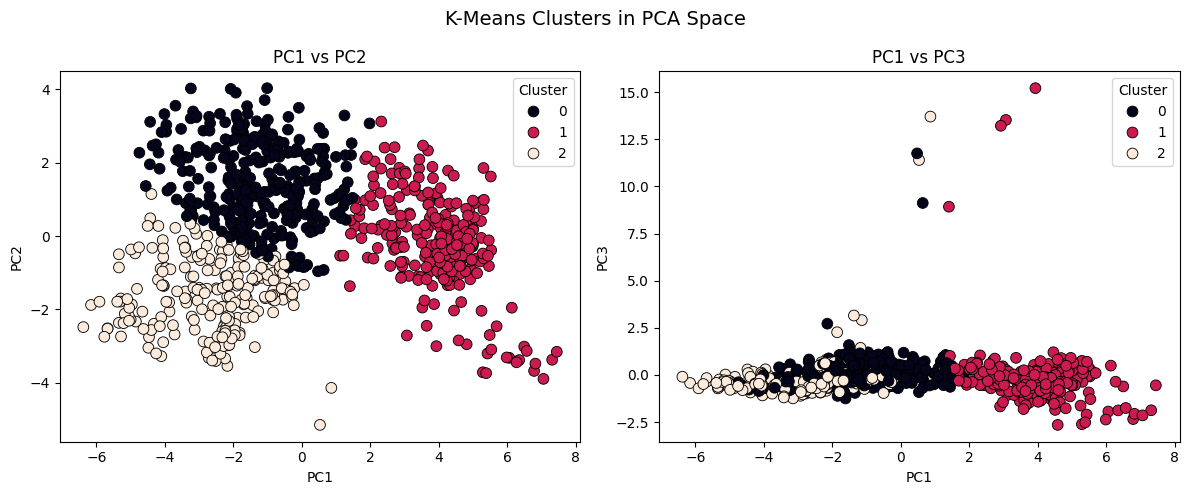

In [14]:
# Creating the plot figure
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Visualize PC1 vs PC2 and add subplot label
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster', palette='rocket',
    data=X_pca_df, s=60, edgecolor='k',
    ax=axes[0]
)
axes[0].set_title("PC1 vs PC2")

# Visualize PC1 vs PC3 and add subplot label
sns.scatterplot(
    x='PC1', y='PC3',
    hue='Cluster', palette='rocket',
    data=X_pca_df, s=60, edgecolor='k',
    ax=axes[1]
)
axes[1].set_title("PC1 vs PC3")

# Set title and display plot
plt.suptitle("K-Means Clusters in PCA Space", fontsize=14)
plt.tight_layout()
plt.show()

Using K‑Means with $k = 3$ on the standardized features, the algorithm identified three clusters of relatively balanced size that broadly reflect structure in the dataset. The visualizations show that while the clusters are reasonably well separated, there is still overlap and the presence of outliers, indicating that the boundaries between groups are not perfectly distinct. This suggests that K‑Means captures meaningful patterns and provides useful exploratory insight into the data’s organization, but it does not fully resolve the similarities between the underlying classes.

#### 3.3.2 Hierarchical

Since K‑Means clustering did not fully recover the true class distribution, it is worth exploring whether an alternative unsupervised method can provide clearer separation. Hierarchical clustering offers a different perspective: rather than partitioning the data into $k$ groups directly, it builds a hierarchy of nested clusters that can be visualized in a dendrogram. By examining this structure and cutting the tree at different levels, we can assess whether the natural groupings in the data align more closely with the known categories of cars, vans, and buses.

In [15]:
# Fit Hierarchical Clustering on PCA-reduced data
hc = AgglomerativeClustering(n_clusters=3, linkage="ward")
hc_labels = hc.fit_predict(X_pca_df)

# Add cluster labels and true classes
X_pca_df["HC_Cluster"] = hc_labels
X_pca_df["True_Class"] = y

# Compare clusters with true classes
X_pca_df.groupby(["HC_Cluster", "True_Class"]).size()

HC_Cluster  True_Class
0           bus            46
            car           212
            van             6
1           bus            79
            car           130
            van           103
2           bus            80
            car            71
            van            86
dtype: int64

The grouped summary of clusters and true classes shows that hierarchical clustering produced mixed results, with cars and vans frequently grouped together and buses distributed across multiple clusters rather than forming a single distinct group. While the table highlights how the algorithm assigned samples, one of the distinctive strengths of hierarchical clustering is that it does not simply produce a fixed partition. Instead, it builds a hierarchy of nested clusters that can be visualized in a dendrogram. By examining this structure, we can see the order in which clusters merge and identify whether certain categories separate earlier from the rest, while others remain closely linked until later in the process. This hierarchical view provides additional context for interpreting the structure of the data beyond the grouped counts.

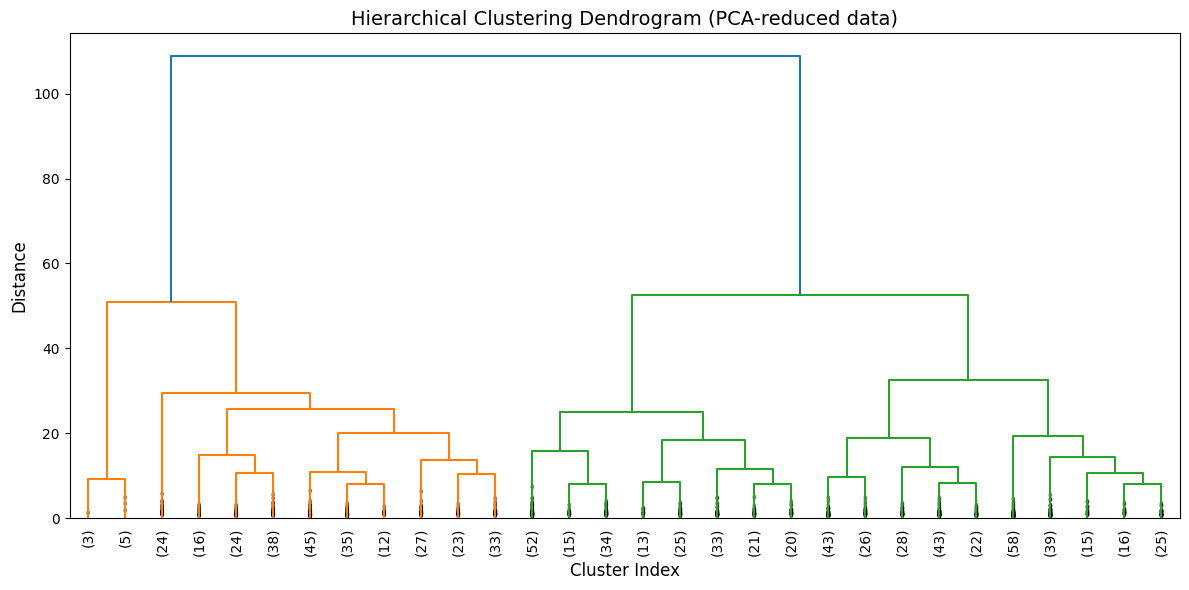

In [16]:
# Compute the linkage matrix using Ward's method
Z = linkage(X_pca_df.iloc[:, :6], method='ward')

# Creating the plot figure
plt.figure(figsize=(12, 6))

# Plot the dendrogram
# Show only the last p merges for readability
# Set number of leaf clusters shown with p=30
dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True
)

# Add plot title and labels
plt.title("Hierarchical Clustering Dendrogram (PCA-reduced data)", fontsize=14)
plt.xlabel("Cluster Index", fontsize=12)
plt.ylabel("Distance", fontsize=12)

# Display plot
plt.tight_layout()
plt.show()

The dendrogram revealed that the dataset separates into two major branches, with one side fragmenting into many smaller subgroups while the other divides more evenly into balanced clusters. This pattern suggests that part of the data is relatively homogeneous, while the remainder is more heterogeneous and difficult to separate cleanly. The result reinforces the observation that cars and vans remain closely intertwined in feature space, while buses show some tendency to form more distinct subgroups but are still spread across multiple branches.

Hierarchical clustering is therefore most valuable here as an exploratory tool only. It highlights the nested structure of the data and provides flexibility in how clusters are defined, but it does not fully resolve the overlap between certain classes. In practice, this makes it best suited for gaining intuition about the data’s organization rather than serving as a definitive classification method.

#### 3.3.3 DBSCAN

Both K‑Means and hierarchical clustering provided useful perspectives on the dataset, but neither aligned cleanly with the true vehicle classes. To explore the structure further, we now turn to DBSCAN (Density‑Based Spatial Clustering of Applications with Noise). Unlike K‑Means or hierarchical clustering, DBSCAN does not require us to pre‑specify the number of clusters and is well‑suited to identifying groups of varying shapes and densities, while also labeling outliers as noise. This makes it a natural next step to test whether a density‑based approach can uncover more meaningful separation in the data or highlight points that do not belong to any cluster at all.

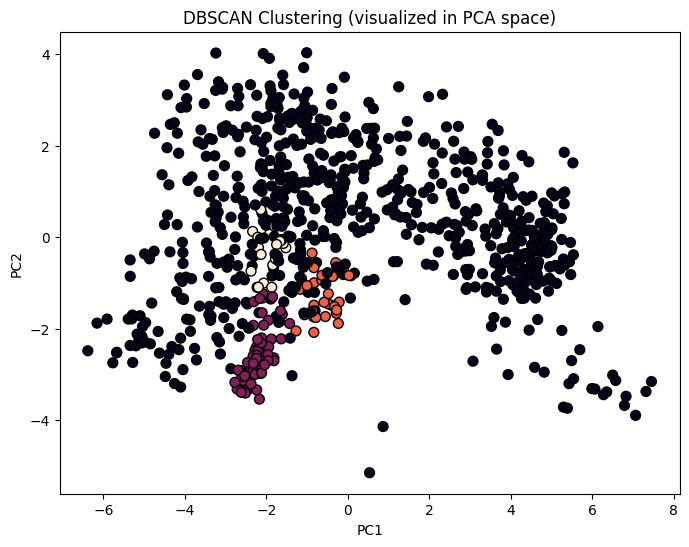

In [17]:
# Fit DBSCAN on scaled original features rather than PCA-reduced data
# to preserve full distance information
db = DBSCAN(eps=1.5, min_samples=20)
labels = db.fit_predict(X_scaled)

# Add cluster labels to DataFrame
X_pca_df["DB_Cluster"] = labels

# Creating the plot figure
plt.figure(figsize=(8,6))

# Plot clusters using PCA components, colored by DBSCAN labels
plt.scatter(
    X_pca_df["PC1"],
    X_pca_df["PC2"],
    c=X_pca_df["DB_Cluster"],
    cmap="rocket",
    edgecolor="black",
    s=50
)

# Add title and labels
plt.title("DBSCAN Clustering (visualized in PCA space)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Display plot
plt.show()

In [18]:
# Determine the number of clusters
nr_dbscan_clusters = len(np.unique(labels))
print("Number of clusters formed by DBSCAN:", nr_dbscan_clusters)

Number of clusters formed by DBSCAN: 4


With DBSCAN at `eps=1.5` and `min_samples=20`, four clusters emerged, with one dominant cluster containing the majority of points. The smaller groups were more distinct from each other, yet still overlapped with the main cluster when visualized in PCA space. This outcome aligns with the results from K‑Means and Hierarchical clustering, reinforcing the conclusion that the dataset does not exhibit sufficient feature separation for clustering algorithms to recover the true classes in a reliable way.

## 4 - Conclusion

Across K‑Means, Hierarchical, and DBSCAN clustering, the results consistently revealed one dominant group alongside smaller, overlapping sub‑clusters. These clusters were highly imbalanced and did not align with the true vehicle classes. By contrast, supervised models previously developed for Prospect Auto achieved strong classification performance by leveraging labeled data, with Logistic Regression emerging as the most balanced and reliable model, achieving 95.1% accuracy.

Taken together, these findings indicate that unsupervised clustering is not a viable alternative for Prospect Auto’s classification needs, though it may still provide value for exploratory analysis or anomaly detection in future applications. For a complete discussion of the supervised models previously developed, see the [Supervised Learning Project Notebook](../notebooks/01-supervised.ipynb).